In [1]:

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if n > 0:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = float(self.sum) / self.count

    def update_count(self, multiplier):
        self.count = self.count * multiplier
        self.avg = float(self.sum) / self.count


In [12]:
root_dir='../file_zila/'

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import torch
from torchvision import transforms
from OrigianlABD.models.resnet import resnet32
import gpytorch
# gpytorch.mlls.ExactMarginalLogLikelihood()

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if n > 0:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = float(self.sum) / self.count

    def update_count(self, multiplier):
        self.count = self.count * multiplier
        self.avg = float(self.sum) / self.count

def scores_from_path(before_shuffle,save_path,repeat=1):
        
    dataset_stats = {
        'CIFAR10' : {'mean': (0.49139967861519607, 0.48215840839460783, 0.44653091444546567),
                    'std' : (0.2470322324632819, 0.24348512800005573, 0.26158784172796434),
                    'size' : 32},
        'CIFAR100': {'mean': (0.5070751592371323, 0.48654887331495095, 0.4409178433670343),
                    'std' : (0.2673342858792409, 0.25643846291708816, 0.2761504713256834),
                    'size' : 32},   
        'ImageNet': {'mean': (0.485, 0.456, 0.406),
                    'std' : (0.229, 0.224, 0.225),
                    'size' : 224},      
        'TinyImageNet': {'mean': (0.4389, 0.4114, 0.3682),
                    'std' : (0.2402, 0.2350, 0.2268),
                    'size' : 64},  
                    }

    mean=dataset_stats['CIFAR100']['mean']
    std=dataset_stats['CIFAR100']['std']
    test_transforms=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
                                ])


    def accuracy(output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].view(-1).float().sum().item()
                res.append(correct_k*100.0 / batch_size)

            if len(res)==1:
                return res[0]
            else:
                return res
    from torchvision import datasets
    dataset_path=os.path.join('../data/dataset/cifar100/')
    test_data = datasets.CIFAR100(root=dataset_path, train=False,
                                    download=False, transform=test_transforms)
    bsz=100
    subsets = {target: torch.utils.data.Subset(test_data, (np.array(test_data.targets)==target).nonzero()[0]) for target in range(100)}
    testloader = {target: torch.utils.data.DataLoader(subset,batch_size=bsz) for target, subset in subsets.items()}

    our_model=resnet32(100)
    # our_model.load_state_dict(torch.load(os.path.join(ours_ids,'class.pth'),map_location='cpu'))
    our_model.load_state_dict(torch.load(os.path.join(save_path,'class_{}.pth'.format(repeat)),map_location='cpu'))
    # our_model.load_state_dict(torch.load(os.path.join(abd_ids,'class.pth'),map_location='cpu'))
    our_model.eval()
    our_model.to('cuda')

    # abd_model.load_state_dict(torch.load(abd_path+'class.pth'))
    #print("our model", tbd_model)
    import torch.nn as nn
    y_true = []
    y_pred_abd = []
    y_pred_tbd = []
    m = nn.Softmax(dim=1)
    loss=nn.NLLLoss(reduction='none')
    # accs=AverageMeter()
    # dict_list={}
    accs=AverageMeter()
    inc=0

    scores=[]
    for cls_idx in range(100):
        scores.append(AverageMeter())
    for i in range(100): #total class num
        # result = 0.0
        for batch_idx, (inputs, targets) in enumerate(testloader[int(i)]):#NLL calcuate by same class group
            with torch.no_grad():
                inputs, targets = inputs.cuda(), targets.cuda()
                output_tbd = our_model(inputs)
                before_shuffle=before_shuffle.expand(output_tbd.shape[0],output_tbd.shape[1])
                outputs=torch.gather(output_tbd,1,before_shuffle)#indexing

                outputs=m(outputs)
                score=outputs.sum(dim=0)
                # print(score.sum())

                # if i==1:
                #     print(outputs.argmax(dim=1))
                #     print(i,targets)
                #     raise NotImplementedError
                # result += -loss(output_tbd,targets)
                # result += -loss(m(torch.gather(output_tbd,1,a)),targets)
                # result += -loss(m(outputs),targets).sum()
            # print("NLL value per ",i,"-th class :", result.item())

            acc = accuracy(outputs.detach(),targets)
            accs.update(acc,inputs.size(0))
            for cls_idx in range(100):
                scores[cls_idx].update(score[cls_idx],inputs.size(0))
        # dict_list[i]=result.item()
        print("\r{:3d}/{:3d}".format(inc,100),end='')
        inc+=1

    for cls_idx in range(100):
        scores[cls_idx]=scores[cls_idx].sum
    return scores

 99/100
di
STD: 0.02883109996219079


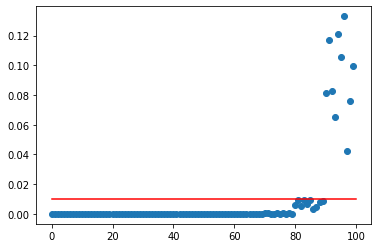

In [62]:
# DI
post_shuffle=torch.tensor([23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]) # abds
before_list=[]
for xi in range(100):
    before_list.append((post_shuffle==xi).nonzero().item())
before_shuffle=torch.tensor(before_list).to('cuda').unsqueeze(0)


di_path=os.path.join(root_dir,'di_task-10')
if not os.path.exists(di_path):
    raise NotADirectoryError
scores=scores_from_path(before_shuffle,di_path)
arr2_DI=np.array(torch.tensor(scores).cpu().numpy()/1000000)#[before_list]

# plt.ylim (0,0.03)
print("\ndi")
print("STD: {}".format(arr2_DI.std()))

plt.plot([0,100],[0.01,0.01],color='r')
plt.scatter(before_list,arr2_DI)
plt.savefig(os.path.join(di_path,'scatter_DI.pdf'))

 99/100
abd
STD: 0.004232503027742935


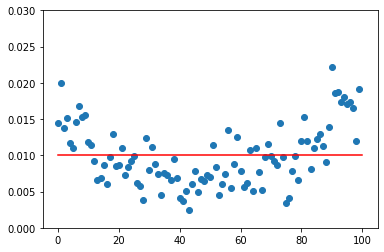

In [59]:
# ABD
post_shuffle=torch.tensor([23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]) # abds
before_list=[]
for xi in range(100):
    before_list.append((post_shuffle==xi).nonzero().item())
before_shuffle=torch.tensor(before_list).to('cuda').unsqueeze(0)
abd_path=os.path.join(root_dir,'abd_task-10')
if not os.path.exists(abd_path):
    raise NotADirectoryError
scores=scores_from_path(before_shuffle,abd_path,1)
arr2_abd=np.array(torch.tensor(scores).cpu().numpy()/1000000)#[before_list]
print("\nabd")
print("STD: {}".format(arr2_abd.std()))
plt.ylim (0,0.03)
plt.plot([0,100],[0.01,0.01],color='r')
plt.scatter(before_list,arr2_abd)

 99/100
lwf
STD: 0.03162523716722005


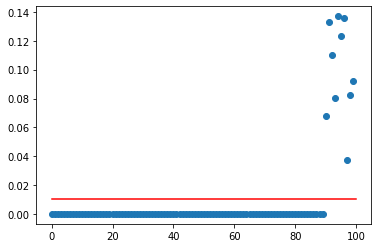

In [58]:

#lwf
post_shuffle=torch.tensor([23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]) # abds
before_list=[]
for xi in range(100):
    before_list.append((post_shuffle==xi).nonzero().item())
before_shuffle=torch.tensor(before_list).to('cuda').unsqueeze(0)
lwf_path=os.path.join(root_dir,'lwf_task-10')
if not os.path.exists(lwf_path):
    raise NotADirectoryError
scores=scores_from_path(before_shuffle,lwf_path)
arr2_lwf=np.array(torch.tensor(scores).cpu().numpy()/1000000)#[before_list]
print("\nlwf")

print("STD: {}".format(arr2_lwf.std()))
# plt.ylim (0,0.03)
plt.plot([0,100],[0.01,0.01],color='r')
plt.scatter(before_list,arr2_lwf)

 99/100
Ours
STD: 0.0027423394404068853


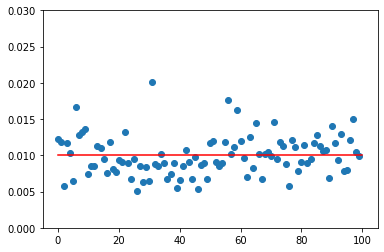

In [57]:
#ours
post_shuffle=torch.tensor([23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]) # abds

before_list=[]
for xi in range(100):
    before_list.append((post_shuffle==xi).nonzero().item())
before_shuffle=torch.tensor(before_list).to('cuda').unsqueeze(0)
ours_path=os.path.join(root_dir,'ours_task-10')
if not os.path.exists(ours_path):
    raise NotADirectoryError
scores=scores_from_path(before_shuffle,ours_path,243)# 243

arr2_ours=np.array(torch.tensor(scores).cpu().numpy()/1000000)#[before_list]
print("\nOurs")
print("STD: {}".format(arr2_ours.std()))
plt.ylim (0,0.03)
plt.plot([0,100],[0.01,0.01],color='r')
plt.scatter(before_list,arr2_ours)